# Implémentez un modèle de scoring

L'objectif est de développer un modèle de scoring de la probabilité de défaut d'un client

Différents modèles de ML sont testés rapidement et le plus performant est sélectionné.

Ensuite, une fonction d'optimisation via la librairie "hyperopt" est définie. Elle a permis d'optimiser des paramètres suivant deux métriques différentes: la métrique technique f1_score et une métrique bancaire custom_score faite sur mesure pour notre problème. Les paramètres optimisés sont ceux du modèle ML 

Dans une dernière partie, le modèle final ainsi que la méthode shap ont permis d'étudier quelles étaient les variables les plus influentes sur la prédiction de la solvabilité d'un client, d'un point de vue global puis local i.e pour un client spécifique.

## librairies

In [68]:
# Load packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


# Package pour augmenter la data
from imblearn.over_sampling import SMOTE

# Metrics de ML
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer,roc_curve,confusion_matrix,accuracy_score,recall_score,precision_score,f1_score

# Packages de cross_validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# Packages hyperopt pour la séléction d'hyperparamètres
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Modèles de ML
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier


import warnings
warnings.filterwarnings("ignore")





## chargement data

In [69]:
data=pd.read_csv('data.csv')
target=pd.read_csv('target.csv')
test=pd.read_csv('test_set.csv')

In [70]:
data.drop('Unnamed: 0',axis=1,inplace=True)
test.drop('Unnamed: 0',axis=1,inplace=True)
target.drop('Unnamed: 0',axis=1,inplace=True)

In [71]:
#Set SK_ID_CURR as index
data.set_index('SK_ID_CURR' ,inplace=True)
test.set_index('SK_ID_CURR' ,inplace=True)

In [72]:
target.value_counts(sort=False)

TARGET
0.0       282682
1.0        24825
dtype: int64

In [73]:
24825/282682

0.08781952865764357

on observe un désequilibre de classe 92% et 8%...

In [74]:
# matrice X et y
X=data
y=target.values

## Séléction du meilleur modèle

## Choix des métriques

#### les défaillants forment la classe positive
#### les non-défaillants forment la classe négative

### Objectif de la modélisation :

#### ne pas prédire un client non-défaillant s'il est défaillant ==> minimiser le nombre de faux négatifs (erreur de type II) (prédit non-défaillant mais client défaillant). Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise.

#### ne pas prédire de défaillant si le client n'est pas défaillant donc minimiser les faux positifs (erreur de type I) (classe 1 défaillant alors que non-défaillant dans la réalité). Si un non-défaillant est prédit défaillant, le groupe Home Crédit aura perdu les intérêts de la somme prêtée à l'emprunteur.

### métriques utiles 

#### Recall : la métrique pour déterminer le taux de vrais positif = TP/(TP+FN) --> maximiser
#### Precision:  mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité TP/(TP+FP) -->max
#### F-mesure ou F1 : mix entre le recall et précision --> recall=fonction neg (precision) --> trouver le seuil métier...si logiquement la perte est plus severe quand on donne un credit a un defaillant : on priorise le recall (minimiser les FP) --> Fbeta >1 (moyenne harmonique)
#### Score ROC AUC ; correlation de spearman entre le predit et la cible --> si le modele est ok
#### Score PR AUC : air sous la courbe AUC ...

In [75]:
# Métriques
roc_auc = make_scorer(roc_auc_score, greater_is_better=True,
                      needs_proba=True)
f1_score = make_scorer(fbeta_score, beta=1, greater_is_better=True)


## Modelisation

Nous allons tout d'abord voir les résultats entre des données balanced et unbalanced a travers une modelisation LGBM
Nous utiliserons smot et procederons à un pipline afin d'éviter tout probleme de data leakage

In [76]:
df_resultats = pd.DataFrame({})

In [77]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import time
from sklearn.model_selection import cross_val_score

In [78]:
def process_classification(model, X,y,df_resultats, titre,smote=False, affiche_res=True,
                           affiche_matrice_confusion=True):
    # split data
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                       random_state=11)
    
    if smote==True:
        pipeline=imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                        ['scaler', StandardScaler()],
                                        ['classifier', model]])
    else:
       
        pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                                     ['classifier', model]])

   # Top début d'exécution
    time_start = time.time()
   
   # Entraînement du modèle avec le jeu d'entraînement du jeu d'entrainement
    pipeline.fit(X_train, y_train)
   
   # Prédictions avec le jeu de validation du jeu d'entraînement
    model=pipeline
    y_pred = model.predict(X_test)
 
   # Top fin d'exécution
    time_end = time.time()

   # Probabilités
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcul des métriques
    # Rappel/recall sensibilité
    recall = recall_score(y_test, y_pred)
    
    # Précision
    precision = precision_score(y_test, y_pred)
    # accuracy
    accuracy=accuracy_score(y_test,y_pred)
    # F-mesure ou Fbeta
    f1_score = fbeta_score(y_test, y_pred, beta=1)
    # Score ROC AUC aire sous la courbe ROC
    roc_auc = roc_auc_score(y_test, y_proba)
   
    # durée d'exécution entraînement + validation
    time_execution = time_end - time_start

  # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5, random_state=11,shuffle=True)
  # evaluate the model using cross-validation
    scores = cross_val_score(pipeline, X_train, y_train,scoring='roc_auc', cv=cv)

 # Sauvegarde des performances
    df_resultats = df_resultats.append(pd.DataFrame({
        'Modèle': [titre],
        'Rappel': [recall],
        'Précision': [precision],
        'Accuracy': [accuracy],
        'F1': [f1_score],
        'ROC_AUC': [roc_auc],
        'Durée_tot': [time_execution]}), ignore_index=True)
       
    if affiche_res:
        mask = df_resultats['Modèle'] == titre
        display(df_resultats[mask].style.hide_index())

    if affiche_matrice_confusion:
        fig = plt.figure(figsize=(20,15))
        plt.subplot(221)
        y_pred= model.predict(X_test)
        cf_matrix = confusion_matrix(y_test, y_pred)
        group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
        
        plt.subplot(222)
        y_true=y_test
        y_pred_proba=model.predict_proba(X_test)[:,1]
        fpr,tpr,_ = roc_curve(y_true,y_pred_proba )
        plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()

       
    return df_resultats

### LGBM
Afin d'avoir une première idée des performances possibles, la modélisation par lgbm permettra d'obtenir une baseline.

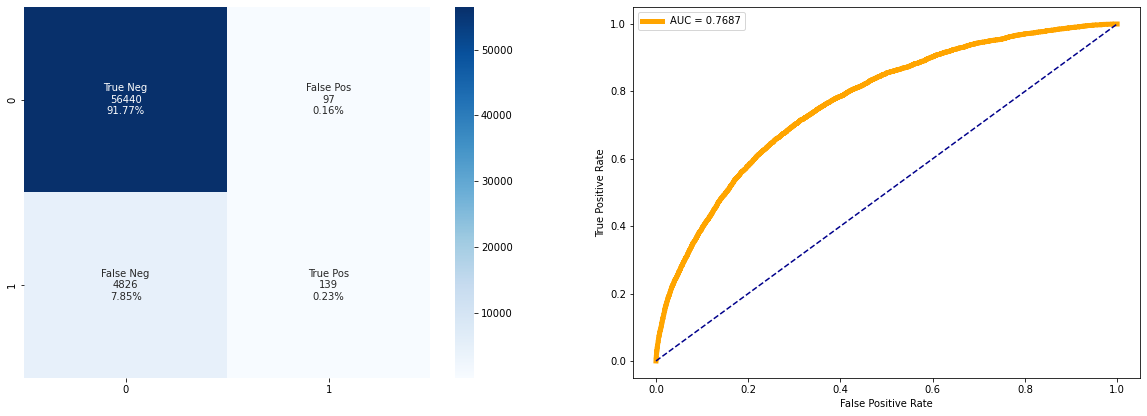

In [79]:
# SANS EQUILIBRAGE DES CLASSES
df_resultats= process_classification(LGBMClassifier(), X,
                                        y,df_resultats,
                                        'lgbm_unbalanced',smote=False)

 fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). 
 résultat attendu car data n'est pas équilibré, avec 91% des individus classés en modalité 0 et 8.78% en modalité 1

Il est donc intéressant de travailler cet Oversampling ) en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

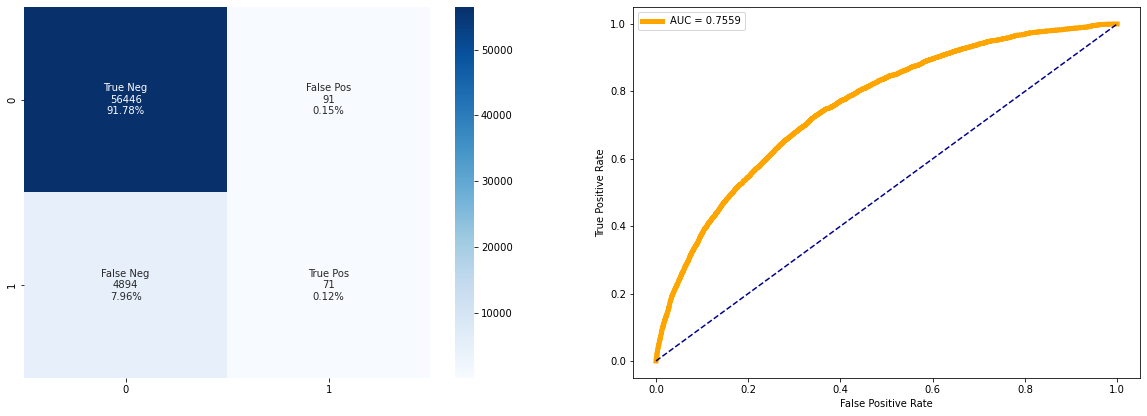

In [80]:
#  AVEC EQUILIBRAGE DES CLASSES 
df_resultats= process_classification(LGBMClassifier(), X,
                                        y,df_resultats,
                                        'lgbm_balanced',smote=True)

Dans la suite de nos modélisations et a fin de pouvoir comparer les modèles nous ferons recour à smot pour tous les algorithmes étant donné que le data est desequilibré

#### logistic regression

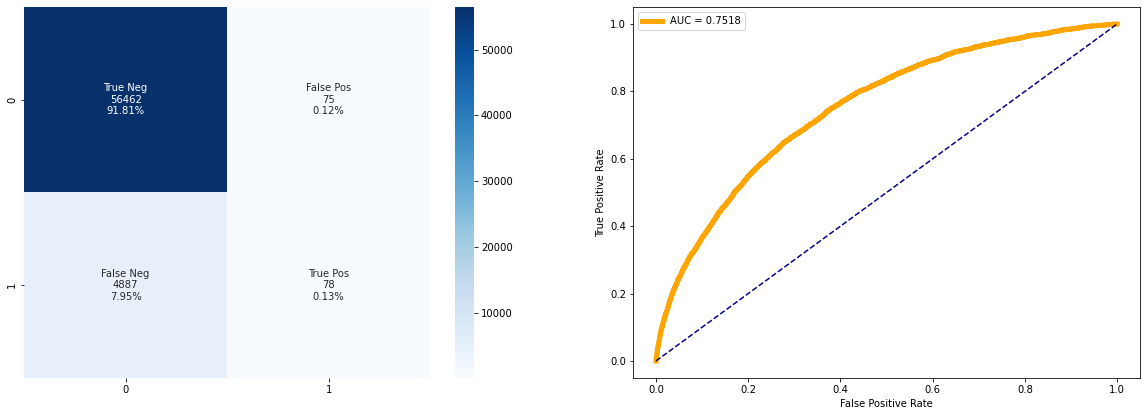

In [81]:
df_resultats= process_classification(LogisticRegression(), X,
                                        y,df_resultats,
                                        'lr_balanced',smote=True)

#### Randomforest

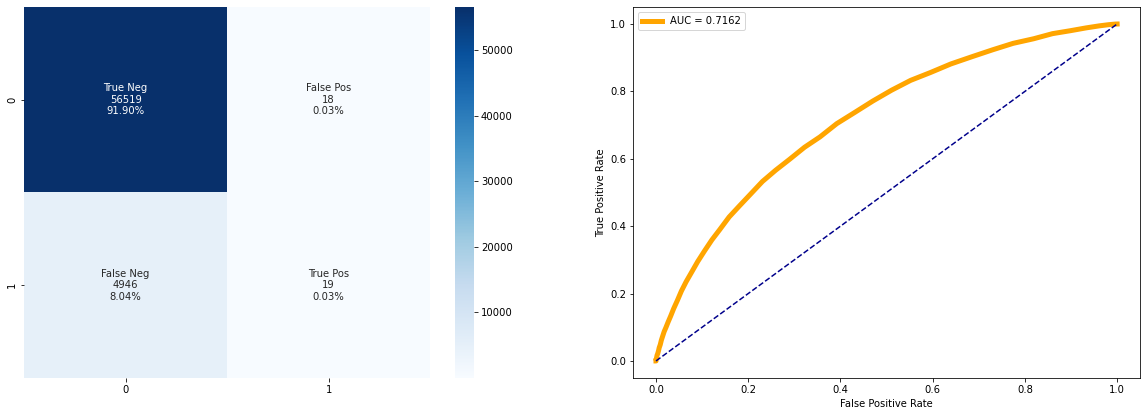

In [82]:
df_resultats= process_classification(RandomForestClassifier(),X,
                                        y,df_resultats,
                                        'rfc_balanced',smote=True)

#### MLPClassifier

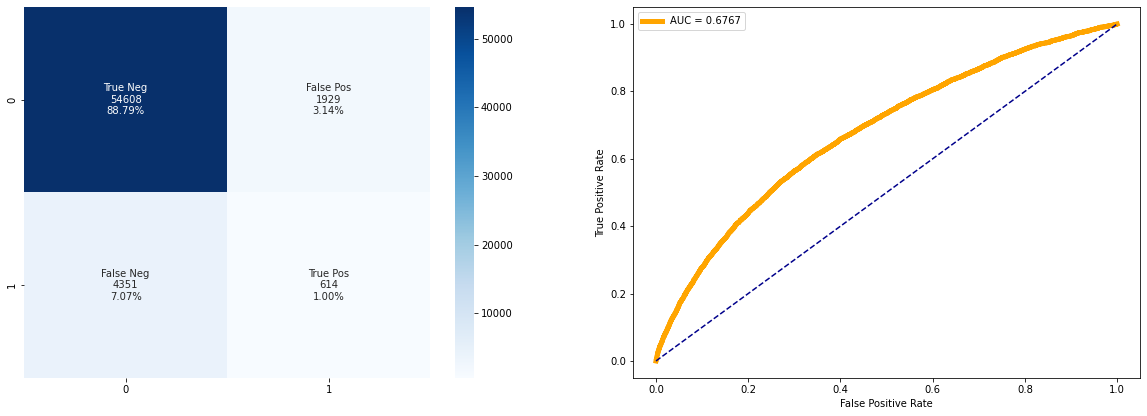

In [83]:
df_resultats= process_classification(MLPClassifier(),X,
                                        y,df_resultats,
                                        'dtc_balanced',smote=True)

#### XGBClassifier

[19:57:23] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:30] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:45] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

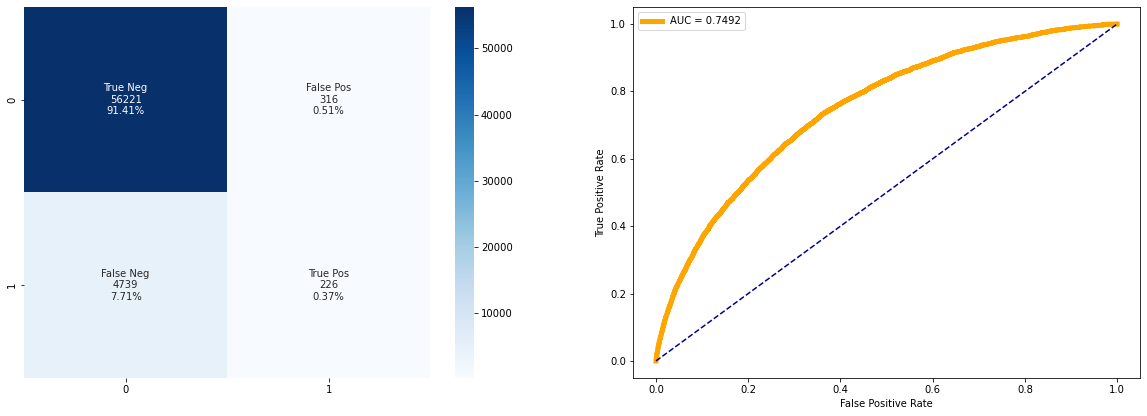

In [84]:
df_resultats= process_classification(XGBClassifier(), X,
                                        y,df_resultats,
                                        'xgb_balanced',smote=True)

#### Dummyclassifier 

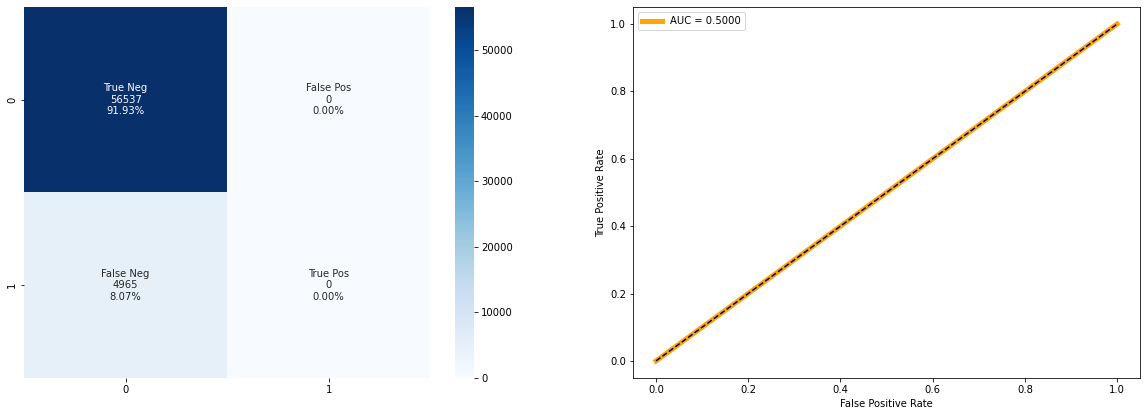

In [85]:
df_resultats= process_classification(DummyClassifier(strategy = 'most_frequent'), X,
                                        y,df_resultats,
                                        'dc_balanced',smote=True)

In [86]:
df_resultats.sort_values('ROC_AUC', ascending=False)

Modèle    Rappel  Précision  Accuracy        F1   ROC_AUC  \
0  lgbm_unbalanced  0.027996   0.588983  0.919954  0.053451  0.768724   
1    lgbm_balanced  0.014300   0.438272  0.918946  0.027697  0.755913   
2      lr_balanced  0.015710   0.509804  0.919320  0.030481  0.751829   
5     xgb_balanced  0.045519   0.416974  0.917808  0.082077  0.749175   
3     rfc_balanced  0.003827   0.513514  0.919287  0.007597  0.716200   
4     dtc_balanced  0.123666   0.241447  0.897889  0.163559  0.676746   
6      dc_balanced  0.000000   0.000000  0.919271  0.000000  0.500000   

     Durée_tot  
0    12.439981  
1    31.302265  
2    27.024946  
5   431.442162  
3   410.975550  
4  1834.335495  
6    16.935945

LGBMClassifier reste le modèle le plus performant selon le couple AUC score/Time.

## Fonction d'optimisation pour le choix des hyperparamètres

Notre choix s'est porté sur le LGBM: en effet, "LightGBM est un cadre de boosting de gradient rapide, distribué et haute performance basé sur des algorithmes d'arbre de décision, utilisé pour le classement, la classification et de nombreuses autres tâches d'apprentissage automatique."

Comment fonctionne le boosting ?

"Le boosting fonctionne sur le principe de l'amélioration des erreurs de l'apprenant précédent par l'intermédiaire de l'apprenant suivant."

"Dans l'apprentissage automatique et les statistiques, le taux d'apprentissage est un paramètre de réglage dans un algorithme d'optimisation qui détermine la taille du pas à chaque itération tout en se déplaçant vers un minimum d'une fonction de perte."

Pour l'optimisation nous faisons le choix hyperopt car il présente un avantage de cout d'exécution et de possibilité que Gridsearch et Randomsearch

In [95]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [177]:
#Parameter 
params = {
    'learning_rate':    hp.uniform('learning_rate',0.1,1),
    'max_depth':        hp.choice('max_depth',np.arange(2, 100, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 50, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree',0.4,1),
    'subsample':        hp.uniform('subsample', 0.6, 1),
    'num_leaves':       hp.choice('num_leaves', np.arange(1, 200, 1, dtype=int)),
    'min_split_gain':   hp.uniform('min_split_gain', 0, 1),
    'reg_alpha':        hp.uniform('reg_alpha',0,1),
    'reg_lambda':       hp.uniform('reg_lambda',0,1),
    'n_estimators':     400 }

In [178]:
def objective(params):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(data,
                                                        target.values,
                                                        test_size=0.2,
                                                        stratify=y,
                                                       random_state=11)
    # pipeline
    
    pipeline=imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                        ['scaler', StandardScaler()],
                                        ['classifier', LGBMClassifier(**params)]])
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    

    cv = StratifiedKFold(5)
    
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc',error_score='raise', cv=cv).mean()

    
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [180]:
%%time
best = fmin(fn=objective, space=params, max_evals=8, algo=tpe.suggest)

100%|████████████████████████████████████████████████| 8/8 [31:37<00:00, 237.15s/trial, best loss: 0.24760982697049094]
CPU times: total: 1h 31min 26s
Wall time: 31min 37s


In [181]:
best

{'colsample_bytree': 0.5474648085893559,
 'learning_rate': 0.24740981330483958,
 'max_depth': 96,
 'min_child_weight': 42,
 'min_split_gain': 0.9913925765858397,
 'num_leaves': 89,
 'reg_alpha': 0.0835810850875347,
 'reg_lambda': 0.18532496692354639,
 'subsample': 0.7061714696160889}

In [182]:
lgbm_optimise=LGBMClassifier(**best)

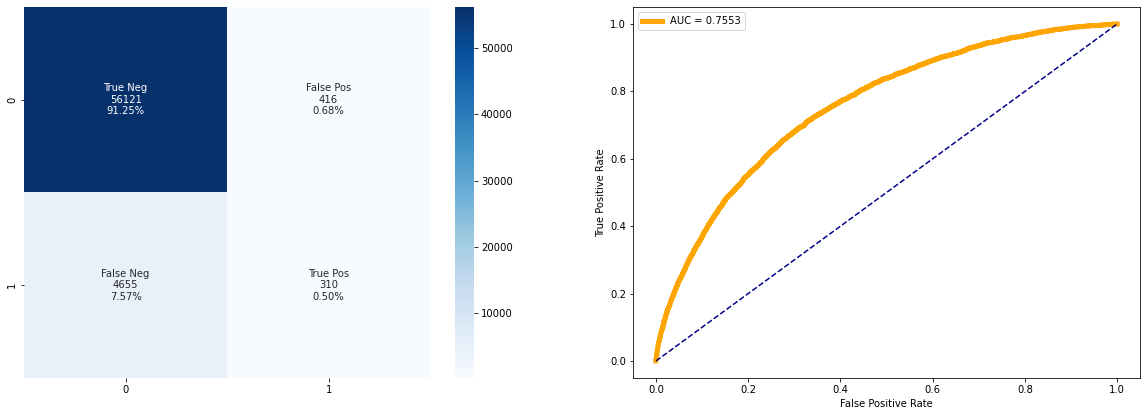

In [183]:
# modelisation avec les hyperparametres optimisés
df_resultats= process_classification(lgbm_optimise, X,
                                        y,df_resultats,
                                        'lgbm_balanced_op',smote=True)

In [184]:
#Check list features importance 
sorted_idx = np.argsort(lgbm_optimise.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_train.columns[index], lgbm_optimise.feature_importances_[index]]) 

['CREDIT_ANNUITY_RATIO', 346]
['REGION_POPULATION_RELATIVE', 222]
['AMT_REQ_CREDIT_BUREAU_YEAR', 206]
['PREVIOUS_LOANS_COUNT', 197]
['CREDIT_GOODS_RATIO', 190]
['EXT_SOURCE_SUM', 182]
['DAYS_BIRTH', 172]
['PREV_APPL_MEAN_CNT_PAYMENT', 169]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 165]
['DAYS_REGISTRATION', 164]
['CAR_EMPLOYED_RATIO', 163]
['DAYS_ID_PUBLISH', 151]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 143]
['EXT_SOURCE_1', 142]
['EXT_SOURCE_2', 138]
['OBS_30_CREDIT_RATIO', 138]
['PREVIOUS_APPLICATION_COUNT', 133]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 133]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 132]
['DAYS_LAST_PHONE_CHANGE', 132]
['ANNUITY_INCOME_RATIO', 127]
['AMT_CREDIT', 126]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 122]
['PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 120]
['AMT_ANNUITY', 118]
['PREV_APPL_MEAN_DAYS_DECISION', 117]
['PREV_BUR_MEAN_DAYS_CREDIT', 117]
['INCOME_EXT_RATIO', 113]
['PREV_APPL_MEAN_DAYS_FIRST_DUE', 113]
['EXT_SOURCE_VAR', 110]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT'

### Seuil et fonction de cout
La fonctionde coût est dérivée en répartissant un coût pour chaque faux positif et faux négatif et en obtenant le revenu global sur la base des prévisions correctes et incorrectes. Supposons les coûts et revenus suivants pour cet ensemble de données sur les défauts de paiement les interest moyen /customer qui rembourse =+10 principal remboursé moyen/customer =8 cout de traintement d'un risque = 3 cela veut dire que : FP : perte de 10 =-10 FN: perte de 8 =-8 TP: perte de 3 =-3 TN: gain de 10 =+10 gain/perte net = FP(-10)+FN(-8)+TP(-3)+TN(+10)

sur la base de de cette fonction nous accordons arbitrairement les poids suivants:

True negative = poids accordé au revenu des intérêts annuels moyen d'un client qui rembourse un prêt. +10

True Positive = poids accordé à la perte évitée si on accorde un crédit à un client défaillant. +1

False Positive = poids accordé au coût représenté par les revenus d'intérêts moyens perdus en prédisant un client en tant que défaillant, ne lui accordant pas le prêt. On considère que ce coût est de moindre importance que le coût d'un faux négatif, car la banque perd dans la cas de FP uniquement les intérêts alors qu'il peut perdre tout le capital dans le cadre de FN. On accorde donc un poids de -1

False Negative = poids accordé au coût représenté par le montant moyen du capital perdu en accordant un prêt à un client défaillant. On considère que ce coût est x fois plus important que le coût des FP. On accorde donc un poids de -20 aux FN.

Dans ce cas le Revenu net = (TN x 10) + (TP x 1) + (FP x -1) + (FN x -20)
Ainsi nous pouvons jouer sur les coeff à partir de l'expertise métier. Pour la suite le choix sera arbitraire.
On peut mettre en perspective et normaliser la fonction de revenu net avec la fonction de revenu net qui permet de produire le modèle prédisant les vraies classes.

In [226]:
# le choix des penalités est arbitraire et le but est de voir l'impact du seuil sur le gain et donc sur la matrice de confusion 

def custom_score(y_reel, y_pred, taux_tn=0, taux_fp=-1, taux_fn=-20, taux_tp=0):
    # Matrice de Confusion
    (tn, fp, fn, tp) = confusion_matrix(y_reel, y_pred).ravel()
    # Gain total
    gain_tot = tn * taux_tn + fp * taux_fp + fn * taux_fn + tp * taux_tp
    # Gain maximum : toutes les prédictions sont correctes
    gain_max = (fp + tn) * taux_tn + (fn + tp) * taux_tp
    # Gain minimum : on accorde aucun prêt, la banque ne gagne rien
    gain_min = (fp + tn) * taux_fp + (fn + tp) * taux_fn
    
    custom_score = (gain_tot - gain_min) / (gain_max - gain_min)
    
    # Gain normalisé (entre 0 et 1) un score élevé montre une meilleure
    # performance
    return custom_score

In [227]:
def determiner_seuil_probabilite(model, X_test, y_test, title, n=1):

    seuils = np.arange(0, 1, 0.01)
    sav_gains = []
 
    for seuil in seuils:

        # Score du modèle : n = 0 ou 1
        y_proba = model.predict_proba(X_test)[:, n]

        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_proba > seuil)
        y_pred = np.multiply(y_pred, 1)
        
        # Sauvegarde du score de la métrique métier
        sav_gains.append(custom_score(y_test, y_pred))
    
    df_score = pd.DataFrame({'Seuils' : seuils,
                             'Gains' : sav_gains})
    
    # Score métrique métier maximal
    gain_max = df_score['Gains'].max()
    print(f'Score métrique métier maximal : {gain_max}')
    # Seuil optimal pour notre métrique
    seuil_max = df_score.loc[df_score['Gains'].argmax(), 'Seuils']
    print(f'Seuil maximal : {seuil_max}')

    # Affichage du gain en fonction du seuil de solvabilité
    plt.figure(figsize=(12, 6))
    plt.plot(seuils, sav_gains)
    plt.xlabel('Seuil de probabilité')
    plt.ylabel('Métrique métier')
    plt.title(title)
    plt.xticks(np.linspace(0.1, 1, 10))

Score métrique métier maximal : 0.637217092218151
Seuil maximal : 0.07


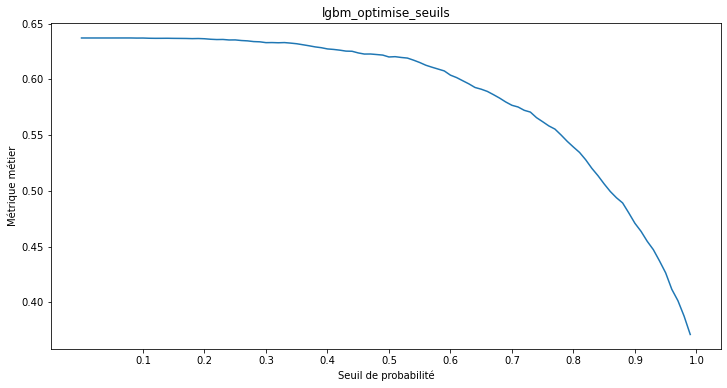

In [228]:
determiner_seuil_probabilite(lgbm_optimise,
                                          X_test, y_test,
                                          'lgbm_optimise_seuils')

### Scores du modèle en prenant en compte le seuil

In [238]:
def classification_seuil(model,seuil, X,y,
                           df_resultats, titre,affiche_res=True,
                           affiche_matrice_confusion=True):
    # split data
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                       random_state=11)

   # Top début d'exécution
    time_start = time.time()
   # define the pipeline
    pipe = Pipeline(steps = [('smote', SMOTE(random_state = 42)), 
                      ('standardscaler', MinMaxScaler()),
                      ('model', model)])
   
   # Entraînement du modèle avec le jeu d'entraînement du jeu d'entrainement
    pipe.fit(X_train, y_train)
   
   # Prédictions avec le jeu de validation du jeu d'entraînement
    
    y_pred = pipe.predict(X_test)
 

   # Probabilités
    y_proba = pipe.predict_proba(X_test)[:, 1]
    # Prédictions avec le jeu de validation du jeu d'entraînement
    # Score > seuil de probabilité : retourne 1 sinon 0
    y_pred = (y_proba > seuil)
    y_pred = np.multiply(y_pred, 1)
    
    # Top fin d'exécution
    time_end = time.time()
    
    # Calcul des métriques
    # Rappel/recall sensibilité
    recall = recall_score(y_test, y_pred)
    
    # Précision
    precision = precision_score(y_test, y_pred)
    # accuracy
    accuracy=accuracy_score(y_test,y_pred)
    # F-mesure ou Fbeta
    f1_score = fbeta_score(y_test, y_pred, beta=1)
    # Score ROC AUC aire sous la courbe ROC
    roc_auc = roc_auc_score(y_test, y_proba)
   
    # durée d'exécution entraînement + validation
    time_execution = time_end - time_start

  # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5, random_state=1,shuffle=True)
  # evaluate the model using cross-validation
    scoring = ['roc_auc', 'recall', 'precision']
    scores = cross_validate(pipe, X_train, y_train,scoring=scoring, cv=cv)

 # Sauvegarde des performances
    df_resultats = df_resultats.append(pd.DataFrame({
        'Modèle': [titre],
        'Rappel': [recall],
        'Précision': [precision],
        'Accuracy': [accuracy],
        'F1': [f1_score],
        'ROC_AUC': [roc_auc],
        'Durée_tot': [time_execution]}), ignore_index=True)
       
    if affiche_res:
        mask = df_resultats['Modèle'] == titre
        display(df_resultats[mask].style.hide_index())

    if affiche_matrice_confusion:
        fig = plt.figure(figsize=(20,15))
        plt.subplot(221)
        y_pred= model.predict(X_test)
        cf_matrix = confusion_matrix(y_test, y_pred)
        group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
        
        plt.subplot(222)
        y_true=y_test
        y_pred_proba=model.predict_proba(X_test)[:,1]
        fpr,tpr,_ = roc_curve(y_true,y_pred_proba )
        plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()

       
    return df_resultats

Modèle    Rappel  Précision  Accuracy        F1  \
0             lgbm_unbalanced  0.027996   0.588983  0.919954  0.053451   
1               lgbm_balanced  0.014300   0.438272  0.918946  0.027697   
2                 lr_balanced  0.015710   0.509804  0.919320  0.030481   
3                rfc_balanced  0.003827   0.513514  0.919287  0.007597   
4                dtc_balanced  0.123666   0.241447  0.897889  0.163559   
5                xgb_balanced  0.045519   0.416974  0.917808  0.082077   
6                 dc_balanced  0.000000   0.000000  0.919271  0.000000   
7      lgbm_balanced_optimise  0.019335   0.171429  0.913287  0.034751   
8   lgbm_balanced_optimise_vf  0.328298   0.150438  0.796104  0.206329   
9            lgbm_balanced_op  0.062437   0.426997  0.917547  0.108944   
10   lgbm_hyperopt_avec_seuil  0.701108   0.156337  0.670433  0.255665   

     ROC_AUC    Durée_tot  
0   0.768724    12.439981  
1   0.755913    31.302265  
2   0.751829    27.024946  
3   0.716200   410.975550  
4   0.676746  1834.335495  
5   0.749175   431.442162  
6   0.500000    16.935945  
7   0.688009    30.098288  
8   0.671687    19.901099  
9   0.755259    32.506737  
10  0.751536    37.735003

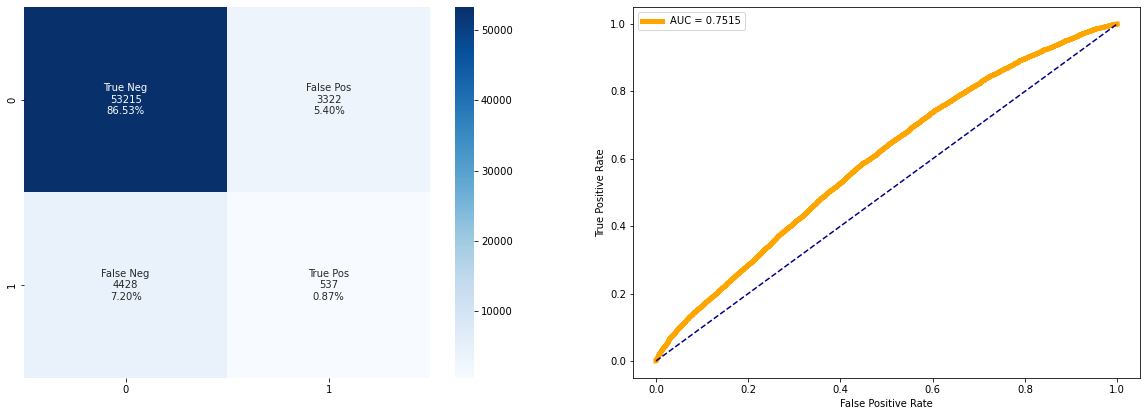

In [241]:
classification_seuil(lgbm_optimise, 0.07,X,y,df_resultats,
                                            'lgbm_hyperopt_avec_seuil')

In [296]:
# Sauvegarde du meilleur modèle 
with open('mypicklefile', 'wb') as best_model:
    pickle.dump(lgbm_optimise, best_model)

## Interprétabilité du modèle

### globale

#### Features importances

In [262]:
def plot_features_importance(features_importance, nom_variables,
                             figsize=(6, 5) ):
    
    df_feat_imp = pd.DataFrame({'feature': nom_variables,
                                'importance': features_importance})
    df_feat_imp_tri = df_feat_imp.sort_values(by='importance')
    
    
    # BarGraph de visalisation
    plt.figure(figsize=figsize)
    plt.barh(df_feat_imp_tri['feature'], df_feat_imp_tri['importance'])
    plt.yticks(fontsize=8)
    plt.xlabel('Feature Importances (%)')
    plt.ylabel('Variables', fontsize=10)
    plt.title('Comparison des Features Importances', fontsize=12)
    plt.show()
    

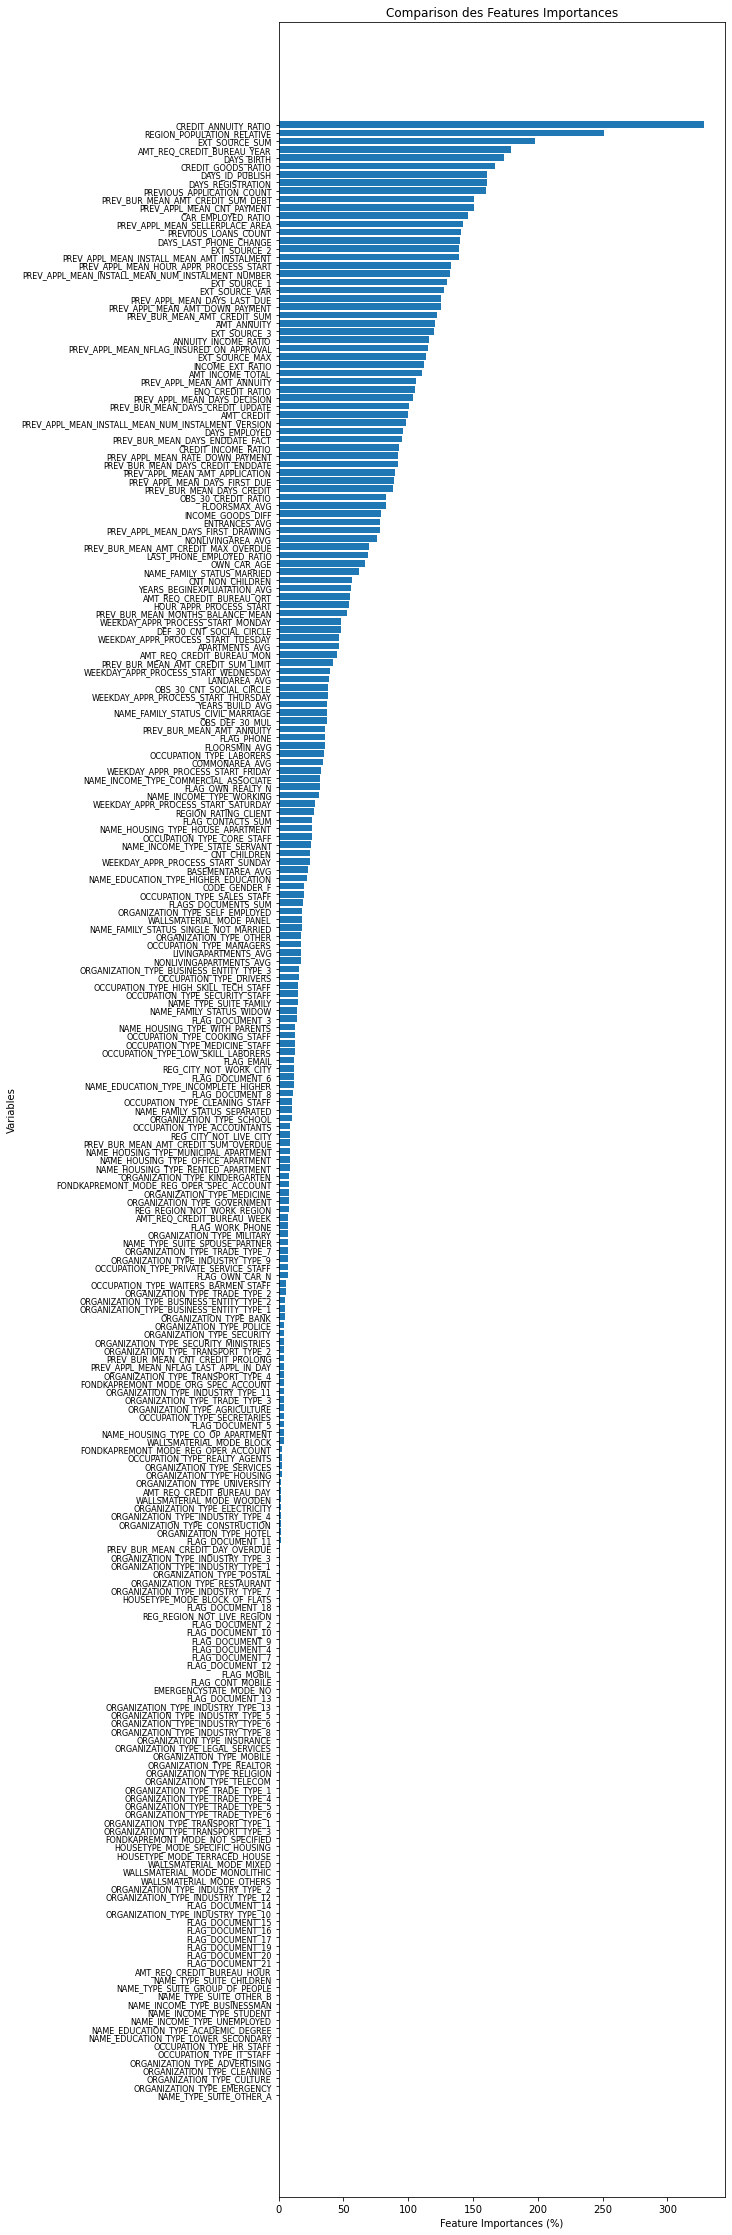

In [266]:
feature_importance_values = lgbm_optimise.feature_importances_

feature_names = list(X_train.columns)
plot_features_importance(feature_importance_values,feature_names, (8, 40))

### SHAP
consiste à calculer la valeur de Shapley pour toutes les variables de tous les individus c’est-à-dire la moyenne de l’impact d’une variable (sur la sortie, donc la prédiction) pour toutes les combinaisons de variables possibles.
La somme des effets de chaque variable expliquera la prédiction.


In [211]:
import shap

In [277]:
# compute SHAP values
explainer = shap.Explainer(lgbm_optimise, X_train)
shap_values = explainer(X_train)

100%|===================| 245950/246005 [14:37<00:00]        

In [278]:
X_train.shape

(246005, 239)

In [279]:
# convertir le numpy array vers un pandas dataframe afin de pouvoir appliquer les méthodes de SHAP
df_xtrain = pd.DataFrame(X_train, 
             columns=data.columns)

df_xtest = pd.DataFrame(X_test, 
             columns=data.columns)

In [280]:
# compute SHAP values
explainer = shap.Explainer(lgbm_optimise, df_xtrain)

In [281]:
shap_values = explainer(df_xtest)

100%|===================| 61325/61502 [03:45<00:00]        

### Feature importance globale

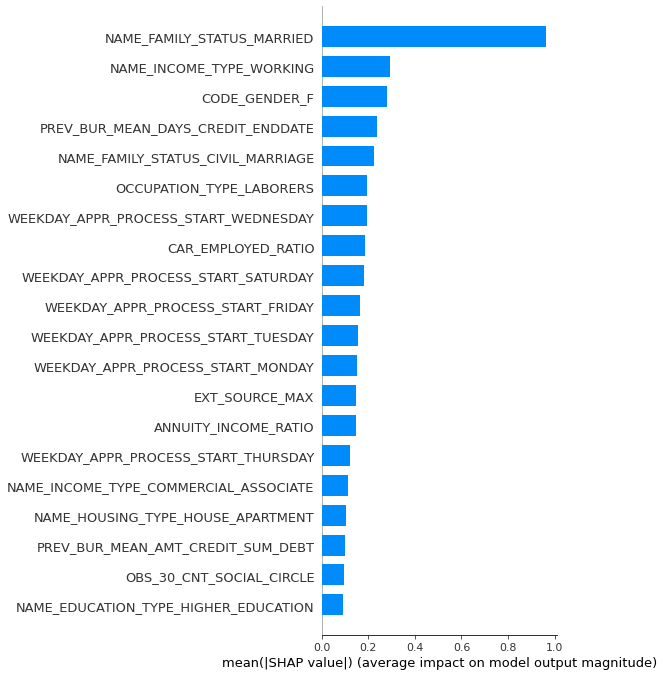

In [282]:
shap.summary_plot(shap_values, 
                  df_xtest, plot_type="bar")

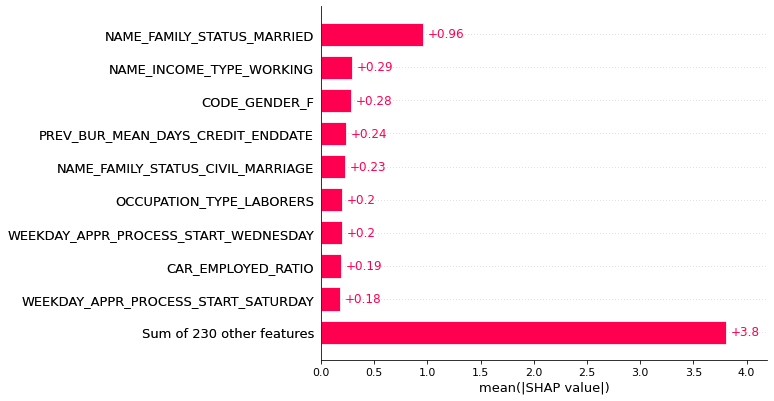

In [283]:
# global feature importance
shap.plots.bar(shap_values)

### Feature importance locale
#### Cas prêt accepté

In [284]:
# probabilité de prediction du client N°0
lgbm_optimise.predict_proba(X_test)[0]

array([0.97, 0.03])

 il y a une probabilité de 97% que la demande de prêt est acceptée (TARGET = 0)% que la  et 3% demande soit refusée (TARGET = 1)

In [285]:
# prédiction du modèle
lgbm_optimise.predict(X_test)[0]

0.0

 Le résultat du client est TARGET =0 --> il y a pas de difficulté de remboursement du prêt --> acceptation du prêt.
regardons la feature importance locale pour comprendre pourquoi.

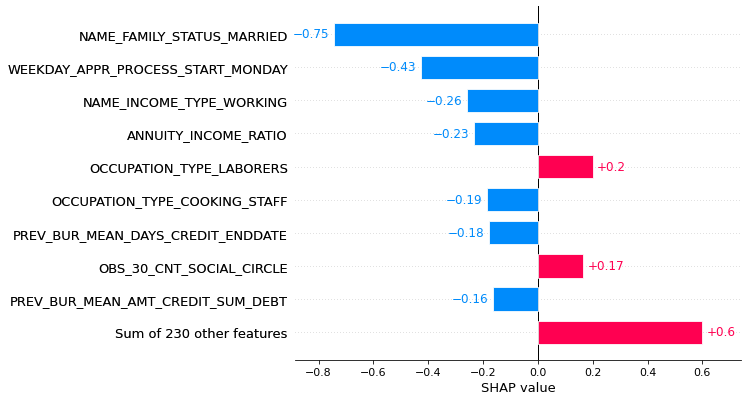

In [287]:
# local feature importance pour le premier client
# compute SHAP values
shap.plots.bar(shap_values[0])

autrement 0.97= -0.75* feat1 -0.43* feat2+.....donc les valeurs de shapley indique que ce client est a risque à cause des coeff en rouge et non risqué a cause des coeff en bleus...

#### cas pret refusé 

In [288]:
# extraire les indices des clients dont leur pet est refusé
x=lgbm_optimise.predict(X_test)
x_refus = [i for i in range(len(x)) if x[i] == 1]
x_refus

[3,
 42,
 49,
 83,
 86,
 120,
 163,
 180,
 197,
 209,
 227,
 240,
 242,
 247,
 257,
 304,
 307,
 308,
 345,
 370,
 378,
 394,
 395,
 400,
 426,
 480,
 484,
 487,
 496,
 498,
 501,
 508,
 512,
 521,
 531,
 535,
 553,
 573,
 577,
 590,
 603,
 604,
 611,
 640,
 649,
 701,
 711,
 727,
 773,
 785,
 796,
 798,
 833,
 834,
 837,
 855,
 873,
 877,
 888,
 890,
 895,
 939,
 955,
 1010,
 1018,
 1041,
 1096,
 1138,
 1220,
 1230,
 1261,
 1273,
 1285,
 1315,
 1352,
 1362,
 1385,
 1386,
 1391,
 1406,
 1421,
 1422,
 1439,
 1451,
 1477,
 1479,
 1526,
 1542,
 1583,
 1639,
 1659,
 1661,
 1663,
 1675,
 1682,
 1709,
 1713,
 1748,
 1753,
 1767,
 1785,
 1794,
 1812,
 1823,
 1827,
 1835,
 1844,
 1859,
 1928,
 1930,
 1947,
 1974,
 1988,
 1995,
 2051,
 2073,
 2084,
 2095,
 2099,
 2120,
 2128,
 2137,
 2168,
 2170,
 2216,
 2231,
 2234,
 2264,
 2291,
 2298,
 2304,
 2313,
 2318,
 2319,
 2322,
 2333,
 2334,
 2342,
 2350,
 2352,
 2418,
 2430,
 2445,
 2489,
 2507,
 2508,
 2519,
 2527,
 2540,
 2544,
 2553,
 2564,
 2610

In [293]:
# choisir client d'indice = 890
lgbm_optimise.predict_proba(X_test)[890]

array([0.43, 0.57])

57% qu'il soit défaillant...voyons pourquoi

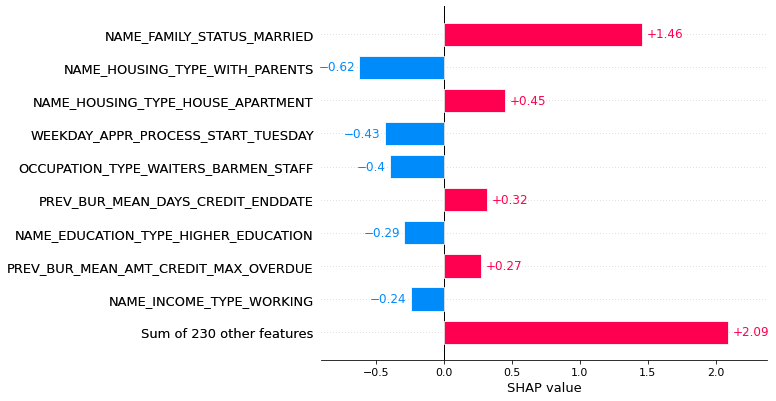

In [294]:
shap.plots.bar(shap_values[890])